# Consumer benchmarks

## Tasks
* measure the speed of consuming messages from Kafka broker
* measure speed of all steps performed during consume message operation
* compute throughput - number of consumable messages per second (worst, best, average scenarios)
* compute possible speedup achievable by using multiple consumers

## Preparation steps
* 100000 messages were sent to Kafka broker into selected topic (in advance)
* consumer has been updated to print durations into log files
* storage has been set to be local (configurable PSQL or SQLite)

## Measurement steps
* aggregator was started, all messages consumed, then stopped
* log were redirected into text file
* then log were transformed into two CSV files used below

## Machine used to run benchmarks
```

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               94
Model name:          Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz
Stepping:            3
CPU MHz:             900.222
CPU max MHz:         3600.0000
CPU min MHz:         800.0000
BogoMIPS:            5424.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            8192K
NUMA node0 CPU(s):   0-7
```

## Main results

Time was measured by the `time` tool. Number of messages in Kafka topic was known in advance. So it is only needed to compute time in seconds (trivial) and average number of messages consumed per second:

In [ ]:
number_of_consumed_messages=100000
time_in_minutes=26
time_in_seconds=time_in_minutes*60
messages_per_second=number_of_consumed_messages/time_in_seconds

Average number of messages consumed per second is:

In [4]:
print(messages_per_second)

64.1025641025641


### Observations
* one thread was used by aggregator (expected)
* just 40% CPU utilization by aggregator process
* rest (60%) spent by I/O operations
* -> I/O (DB I/O + Kafka broker I/O basically are limiting factors)

# Detailed behavior of consumer
It is also possible to analyze log files (or rather CSV files generated from log files). We will use Pandas, Numpy, and Matplotlib libraries here

## Initialization part

In [1]:
# we are going to display graphs and work with data frames
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# let's display all graphs without the need to call .show()
%matplotlib inline

## Loading all data files with raw metrics
Two CSV files were prepared. `consumer_durations.csv` contains just whole duration and offset, nothing else:

In [3]:
# this file contains just whole duration per message (ms) + message offset (int64 value)
durations=pd.read_csv("consumer_durations.csv")

In [4]:
# first ten items taken from this file
durations.head(10)

,Duration,Offset
0,9,0
1,5,1
2,5,2
3,8,3
4,4,4
5,7,5
6,4,6
7,5,7
8,5,8
9,5,9


Second file is named `consumer_steps_durations.csv`. It contains five values measured for each consumed message:
1. time to read message from Kafka topic
1. time to check if the message is correct
1. time to check if it is possible to marshall JSON stored in the message
1. time to check timestamp
1. time to store message body into DB storage

In [6]:
# this file is a bit more complicated - it contains duration of all 5 steps (in ns)
duration_steps=pd.read_csv("consumer_steps_durations.csv")

In [7]:
# first ten items taken from this file
duration_steps.head(10)

,Read,Whitelisting,Marshalling,Time check,DB store
0,296,3,834,11,8506
1,361,5,292,11,6199
2,560,7,436,14,6890
3,555,7,423,14,6539
4,532,7,443,14,6915
5,513,7,426,14,6994
6,490,8,411,14,6815
7,516,7,402,24,6879
8,503,7,388,13,7084
9,512,7,417,13,6904


## Data statistic
CSV files have been consumed and transformed into DataFrames, so it is possible to gather some statistic and display charts.

In [8]:
# let's compute average, best and worst durations (in ms) etc.
durations.describe()

,Duration,Offset
count,100000.00000,100000.000000
mean,15.13289,49999.500000
std,4.48819,28867.657797
min,4.00000,0.000000
25%,14.00000,24999.750000
50%,16.00000,49999.500000
75%,17.00000,74999.250000
max,236.00000,99999.000000


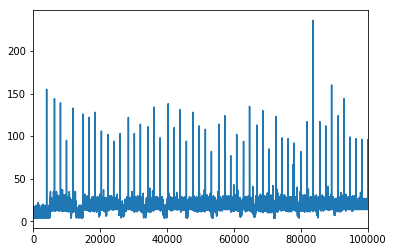

In [9]:
# would be nice to display some graphs as well, especially for overall duration
durations["Duration"].plot()

## Detailed results for first 377 messages

Please note that first x1000 messages are usually processed a bit faster compared to overall average!

In [13]:
# statistic (average, worst, best) for 5 steps for process each message
duration_steps.describe()

,Read,Whitelisting,Marshalling,Time check,DB store
count,377.000000,377.000000,377.000000,377.000000,377.000000
mean,529.071618,8.355438,417.456233,14.994695,7070.602122
std,98.301927,3.996132,52.389436,4.738926,1355.212008
min,296.000000,3.000000,292.000000,11.000000,5683.000000
25%,497.000000,7.000000,398.000000,13.000000,6426.000000
50%,517.000000,7.000000,407.000000,14.000000,6707.000000
75%,538.000000,8.000000,426.000000,14.000000,7008.000000
max,1458.000000,35.000000,1153.000000,48.000000,16190.000000


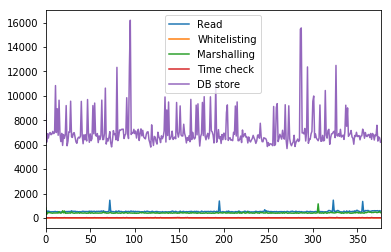

In [14]:
# again, plot the behaviour over time
duration_steps.plot()

In [15]:
# we can see that DB store is the most time demanding operation

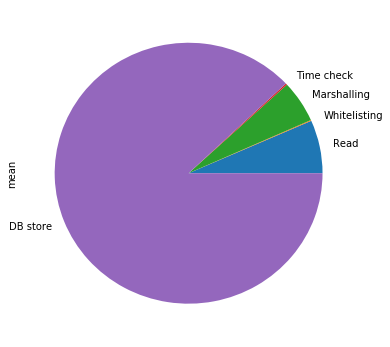

In [16]:
# let's display relative times for each processing step
duration_steps.describe().transpose()["mean"].plot.pie(figsize=(6,6))

## Possible speedup - Amdahl's law
It would be possible to perform first four steps in parallel. So let's compute if its worth it and which speedup is possible

In [17]:
# again, look at steps
duration_steps.describe()

,Read,Whitelisting,Marshalling,Time check,DB store
count,377.000000,377.000000,377.000000,377.000000,377.000000
mean,529.071618,8.355438,417.456233,14.994695,7070.602122
std,98.301927,3.996132,52.389436,4.738926,1355.212008
min,296.000000,3.000000,292.000000,11.000000,5683.000000
25%,497.000000,7.000000,398.000000,13.000000,6426.000000
50%,517.000000,7.000000,407.000000,14.000000,6707.000000
75%,538.000000,8.000000,426.000000,14.000000,7008.000000
max,1458.000000,35.000000,1153.000000,48.000000,16190.000000


We can display stats/speedup for average, worst, and best scenarios. Average might be appropriate for the first version of this benchmark

In [56]:
# let's retrieve means for all five steps
means = duration_steps.describe().transpose()["mean"]

# the first four steps can be (in theory) made parallel
parallel_part = means["Read"]+means["Whitelisting"]+means["Marshalling"]+means["Time check"]
print("Parallel:", parallel_part, "ns")

# last step can be parallelized just in thery - I/O is the bottleneck there
sequence_part = means["DB store"]
print("Sequence:", sequence_part, "ns")

Parallel: 969.8779840848806 ns
Sequence: 7070.6021220159155 ns


In [57]:
# compute parameters for Amdahl's law
p=parallel_part/sequence_part
print("Ratio:", p)

# throughput for one pod/one CPU
t1 = 1000000/(parallel_part+sequence_part)
print("Throughput for 1 pod:", t1, "per second")

Ratio: 0.13717049373559667
Throughput for 1 pod: 124.37068269607927 per second


[124.3706827  133.52878755 136.88874741 138.63294481 139.70096272
 140.422164   140.94188364 141.33420505 141.6408572  141.88713868
 142.08927964 142.25817095 142.40139288 142.52438427 142.63114879
 142.72469904 142.80734535 142.88088913 142.9467557  143.00608755
 143.05981121 143.10868594 143.15333986 143.19429711 143.23199849
 143.26681739 143.2990722  143.32903611 143.35694481 143.38300273
 143.40738808]


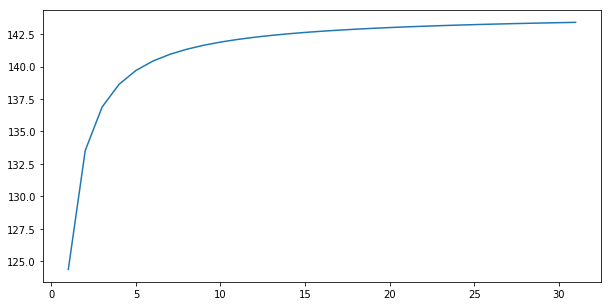

In [58]:
# now compute and display possible speedup for 1..31 CPUs/pods
s=np.arange(1, 32, 1)

# possible throughputs for 1..31 CPUs/pods
t=t1*1/(1-p+p/s)
print(t)

plt.rcParams["figure.figsize"] = (10,5)
fig=plt.figure()
plt.plot(s,t )
plt.show()

In [61]:
# looks like that even for 32 pods/CPUs we can process at most ~143 messages per second
per_second=143
print("Per second", per_second)
print("Per minute", per_second*60)
print("Per hour  ", per_second*60*60)
print("Per day   ", per_second*60*60*24)

Per second 143
Per minute 8580
Per hour   514800
Per day    12355200


In [62]:
# finito